In [1]:
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_grid
import functions_realistic
import functions_plot

from netCDF4 import Dataset

# Procedure in final_bathymetry.ipynb

The goal is to create a no canyon bathymetry for my current resolution (September 27th = (258, 193)). However, the smoothing process takes some time. Therefore, I'm starting off with a lower resolution and then apply the new process on a high resolution domain.

In [2]:
#doubling resolution Jan 26
#quadrupling resolution Jun 28
x_final =  150 #483#120 * 4
y_final =  int(0.75 * x_final)#363#int(0.75 * x_final)

extension_m = 90000#108061

smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504

search_x = [-1000000, -1450000, -1750000, -1400000]

In [3]:
x_final, y_final

(150, 112)

In [4]:
x_region, y_region, z_region = functions_plot.def_regionS()
cmap, norm = functions_plot.Colormap()

In [5]:
x_wall, y_wall, fluid_depth = functions_idealized.base_measurements()

In [6]:
lon_s_corners_can, lat_s_corners_can = functions_grid.match_domain(x_wall, y_wall, search_x)

In [7]:
x_wall_ext = x_wall + extension_m

In [8]:
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

In [9]:
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

lonW, latW, lonE, latE = functions_grid.get_southern_points(lon_g_corners, lat_g_corners)

lon_g_grid, lat_g_grid = functions_grid.create_grid(x_final, y_final, lonW, latW, lonE, latE)

lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

dx (distance between the corner southern point and its neighbour) [km]: 3.47194656891
dx2 (distance between the corner northern point and its neighbour) [km]: 3.4655773447


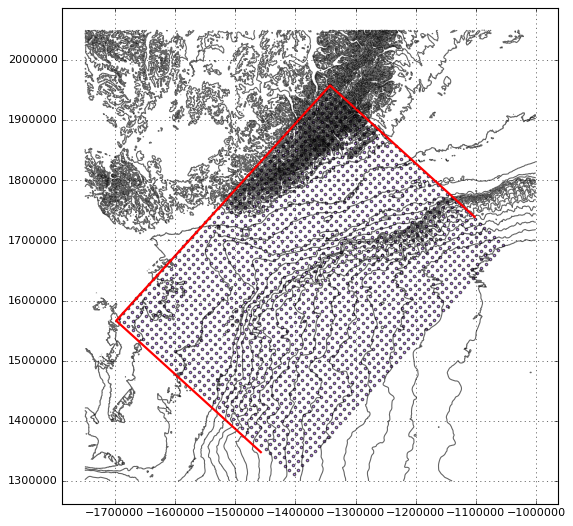

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.scatter(lon_s_grid[::3,::3], lat_s_grid[::3,::3], c='BlueViolet', s=5, alpha=0.6)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)

In [11]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
index = int(extension_m / (dx * 1000))

In [12]:
z_positive = functions_realistic.canyon_for_model(fluid_depth, index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

In [13]:
z_original, z_smoothed = functions_realistic.smooth_canyon(max_norm_depth_diff, smooth_factor, z_positive)

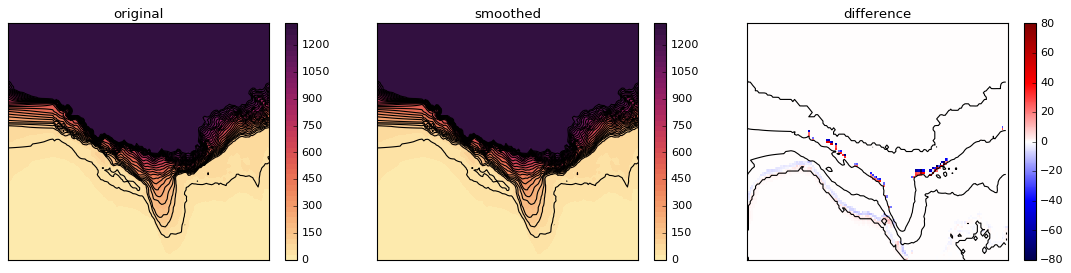

In [14]:
difference = np.subtract(z_smoothed, z_original)
fig, axes = plt.subplots(1,3,figsize=(14,3.5)); plt.tight_layout()
c0 = axes[0].contourf(z_original, 50, cmap = cmo.cm.matter)
c1 = axes[1].contourf(z_smoothed, 50, cmap = cmo.cm.matter)
c2 = axes[2].pcolormesh(difference, cmap = cm.seismic, vmin=-80, vmax=80)
axes[0].contour(z_original, 25, linestyles='solid', colors = 'k')
axes[1].contour(z_smoothed, 25, linestyles='solid', colors = 'k')
axes[2].contour(z_original, levels = [0, 40, 80, 1299], colors='k',linestyles='-')
for cs, i, ttl in zip([c0, c1, c2], np.arange(3), ['original', 'smoothed', 'difference']):
    fig.colorbar(cs, ax = axes[i]); axes[i].set_title(ttl)
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)

# Closer look at realistic canyon

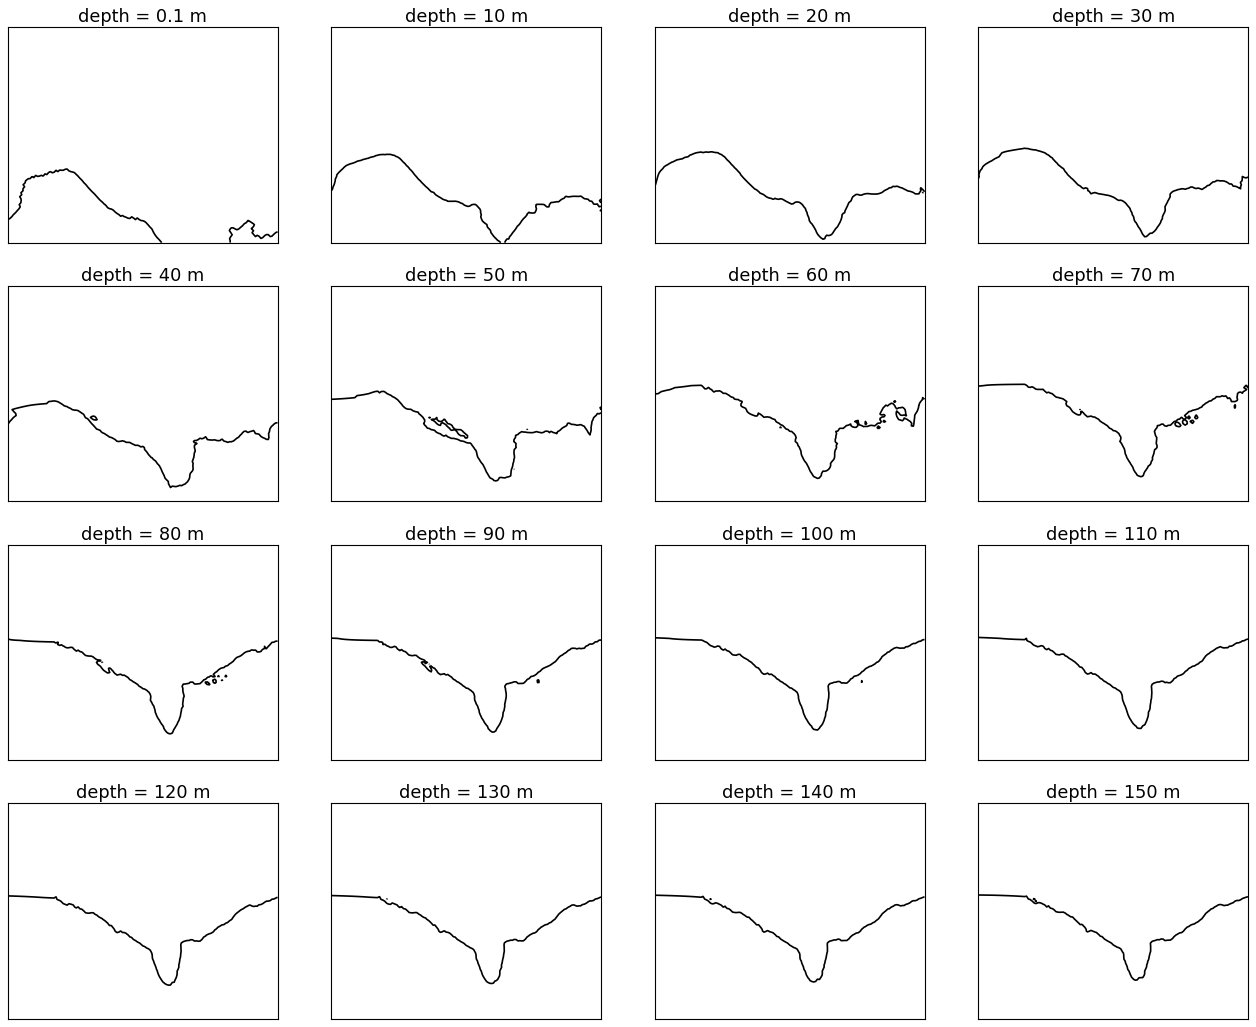

In [15]:
fig, axes = plt.subplots(4, 4, figsize = (20, 16))
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        ax.contour(z_smoothed, levels = [0.1], colors='k',linestyles='-', linewidths=1.5)
        title = 0.1
    else:
        ax.contour(z_smoothed, levels = [i*10], colors='k',linestyles='-', linewidths=1.5)
        title = i*10
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title('depth = '+str(title)+' m', fontsize=16)

In [16]:
def explore_conditions(min_bathy, max_bathy):
    
    inds = np.where((z_smoothed > min_bathy) & (z_smoothed < max_bathy))
    indsx = inds[1]
    indsy = inds[0]
    
    bathy_sub = np.zeros(len(indsx))
    for n in range(len(indsx)):
        bathy_sub[n] = z_smoothed[indsy[n], indsx[n]]
        
    return indsx, indsy, bathy_sub

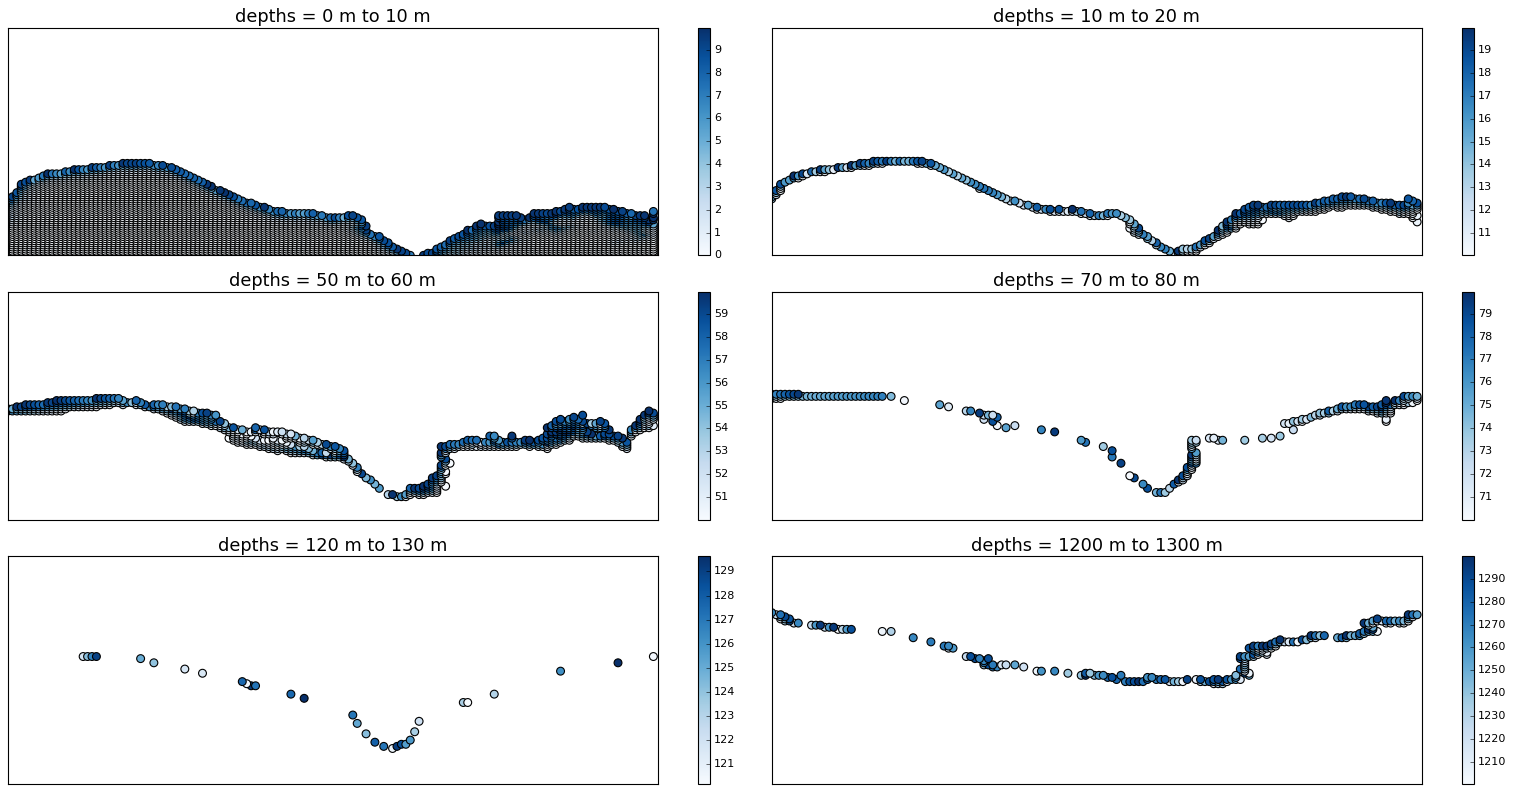

In [17]:
limits_all = [[0, 10], [10, 20], [50, 60], [70, 80], [120, 130], [1200, 1300]]

fig, axes = plt.subplots(3, 2, figsize = (20, 10))
for ax, limits in zip(axes.flatten(), limits_all):
    min_bathy = limits[0]
    max_bathy = limits[1]
    indsx, indsy, bathy_sub = explore_conditions(min_bathy, max_bathy)
    sc = ax.scatter(indsx, indsy, c = bathy_sub, cmap=cm.Blues, s=50)
    ax.set_title('depths = ' + str(min_bathy) + ' m to ' + str(max_bathy) + ' m', fontsize=16)
    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_ylim([0, z_smoothed.shape[-2]])
    ax.set_xlim([0, z_smoothed.shape[-1]])
    fig.colorbar(sc, ax=ax)
fig.tight_layout(w_pad = 0.1)

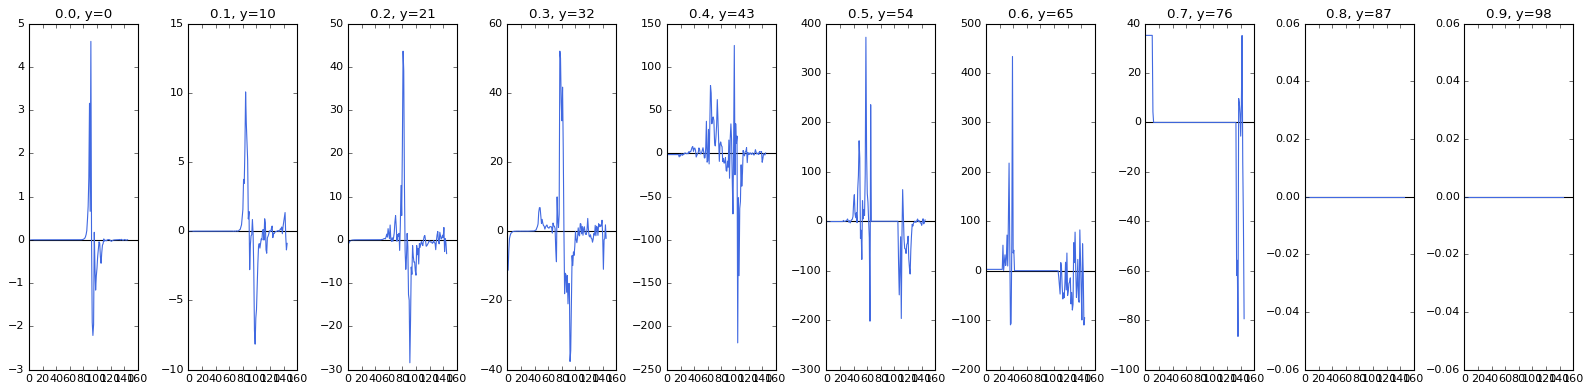

In [22]:
fig, axes  = plt.subplots(1, 10, figsize = (20, 5))
fracs = np.arange(10) * 0.1
for ax, frac in zip(axes.flatten(), fracs):
    j = int((slopes.shape[-2]) * frac)
    ax.axhline(0, c='k')
    ax.plot(slopes[j, :], c='royalblue')
    ax.set_title(str(frac)+', y='+str(j))
fig.tight_layout(w_pad=0.1)

In [100]:
from scipy import interpolate
from scipy.interpolate import Rbf

# ----------------------------------------------------------------------------------------

slopes = np.zeros([z_smoothed.shape[-2], z_smoothed.shape[-1] - 1])

for j in range(z_smoothed.shape[-2]):
    for i in range(z_smoothed.shape[-1] - 1):
        slopes[j, i] = z_smoothed[j, i+1] - z_smoothed[j, i]
        
slopes_row_avg = np.mean(slopes, axis=1)
slopes_row_max = np.max(slopes, axis=1)
slopes_row_min = np.min(slopes, axis=1)

slopes_maxmin = np.zeros_like(slopes)

for j in range(z_smoothed.shape[-2]):
    for i in range(z_smoothed.shape[-1] - 1):
        if slopes[j, i] == slopes_row_max[j]:
            slopes_maxmin[j, i] = 1
        if slopes[j, i] == slopes_row_min[j]:
            slopes_maxmin[j, i] = -1

# ----------------------------------------------------------------------------------------

z_nocanyon1 = np.copy(z_smoothed)
            
for j in range(int(z_smoothed.shape[-2] * 0.4)):
    x_max0 = np.where(slopes[j, :] == slopes_row_max[j])[0][0] -1
    x_min0 = np.where(slopes[j, :] == slopes_row_min[j])[0][0] -1
    
    x_max = x_max0 - 5
    x_min = x_min0 + 5
    
    z_max = z_smoothed[j, x_max]
    z_min = z_smoothed[j, x_min]
    
    x_rim = [x_max, x_min]
    z_rim = [z_max, z_min]
    
    x_interp = np.arange(x_max, x_min + 1)
    
    f = interpolate.interp1d(x_rim, z_rim)
    
    z_interp = f(x_interp)
    
    for i, z in zip(x_interp, z_interp):
        z_nocanyon1[j, i] = z
        
# ----------------------------------------------------------------------------------------

ind_left = 75
ind_right = 95

x_left = np.arange(ind_left)
x_right = np.arange(ind_right, z_smoothed.shape[-1])
x_all = np.concatenate((x_left, x_right))
y_all = np.arange(z_smoothed.shape[-2])

xx, yy = np.meshgrid(x_all, y_all)

z_left = z_smoothed[:, :ind_left]
z_right = z_smoothed[:, ind_right:]
z_all = np.concatenate((z_left, z_right), axis=1)

f = interpolate.interp2d(x_all, y_all, z_all, kind='cubic')

x_new = np.arange(z_smoothed.shape[-1])
y_new = np.copy(y_all)

z_nocanyon2 = f(x_new, y_new)

# ----------------------------------------------------------------------------------------

x_orig = np.array([])
y_orig = np.array([])
for j in range(z_smoothed.shape[-2]):
    x_max0 = np.where(slopes[j, :] == slopes_row_max[j])[0][0] -1
    x_min0 = np.where(slopes[j, :] == slopes_row_min[j])[0][0] -1
    
    x_max = x_max0 - 5
    x_min = x_min0 + 5
    
    x_orig_left = np.arange(0, x_max + 1)
    x_orig_right = np.arange(x_min, z_smoothed.shape[-2])
    x_orig0 = np.concatenate((x_orig_left, x_orig_right))
    x_orig = np.append(x_orig, x_orig0)
    
    y_orig0 = np.ones_like(x_orig0) * j
    y_orig = np.append(y_orig, y_orig0)

z_orig = np.zeros_like(x_orig)
for k in range(len(x_orig)):
    z_orig[k] = z_smoothed[y_orig[k], x_orig[k]]
    

rbf = Rbf(x_orig, y_orig, z_orig, epsilon=2)

xi = np.arange(z_smoothed.shape[-1])
yi = np.arange(z_smoothed.shape[-2])
XI, YI = np.meshgrid(xi, yi)
z_nocanyon3 = rbf(XI, YI)

x_orig.shape, y_orig.shape, z_orig.shape, z_nocanyon3.shape

((9297,), (9297,), (9297,), (109, 147))

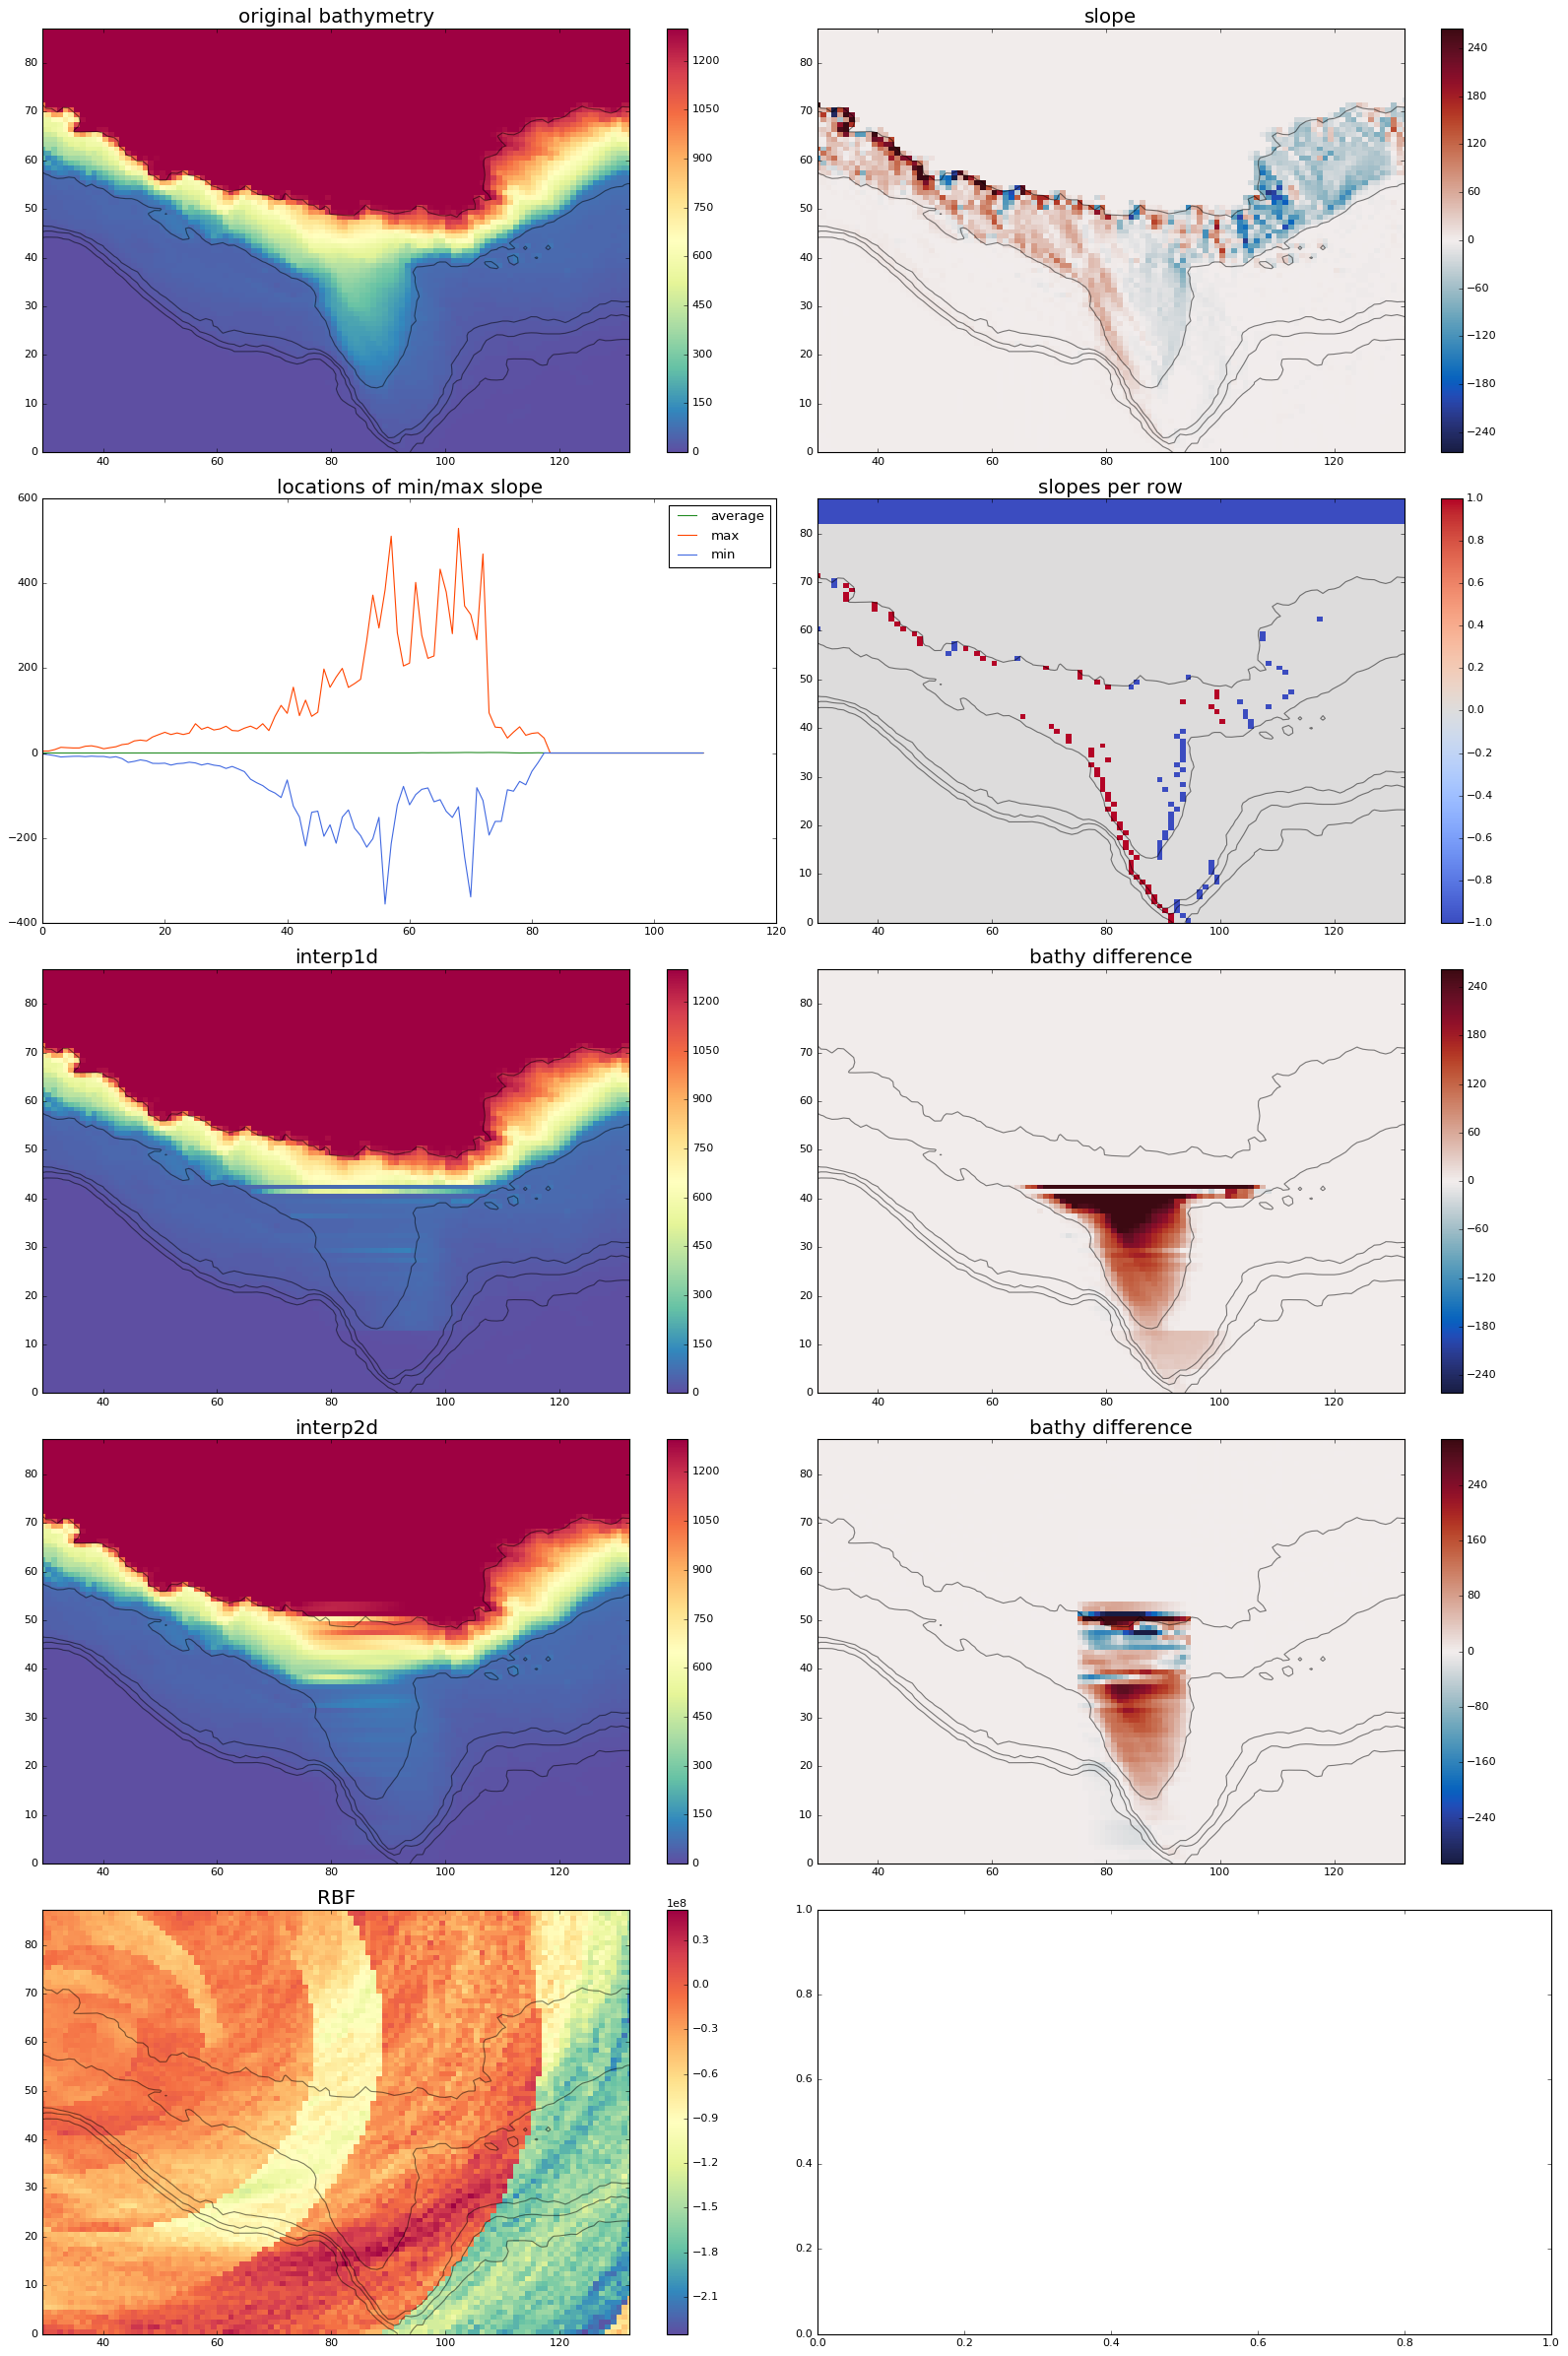

In [102]:
fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8], [ax9, ax10]) = plt.subplots(5, 2, figsize=(20,30))
   
vmmin = z_smoothed.min(); vmmax = z_smoothed.max()
p1 = ax1.pcolormesh(z_smoothed, cmap=cm.Spectral_r, vmin=vmmin, vmax=vmmax)

vm = np.max([abs(slopes), abs(slopes)]) * 0.5
p2 = ax2.pcolormesh(slopes, cmap=cmo.cm.balance, vmin=-1*vm, vmax=vm)

ax3.plot(slopes_row_avg, c='forestgreen', label='average')
ax3.plot(slopes_row_max, c='orangered', label='max')
ax3.plot(slopes_row_min, c='royalblue', label='min')
ax3.legend(); ax3.set_title('locations of min/max slope', fontsize=18)

p4 = ax4.pcolormesh(slopes_maxmin, cmap = cm.coolwarm)

p5 = ax5.pcolormesh(z_nocanyon1, cmap=cm.Spectral_r, vmin=vmmin, vmax=vmmax)

z_diff = z_smoothed - z_nocanyon1
vm = np.nanmax([abs(z_diff), abs(z_diff)]) * 0.5
p6 = ax6.pcolormesh(z_diff, cmap=cmo.cm.balance, vmin=-1*vm, vmax=vm)

p7 = ax7.pcolormesh(z_nocanyon2, cmap=cm.Spectral_r, vmin=vmmin, vmax=vmmax)

z_diff = z_smoothed - z_nocanyon2
vm = np.nanmax([abs(z_diff), abs(z_diff)]) * 0.5
p8 = ax8.pcolormesh(z_diff, cmap=cmo.cm.balance, vmin=-1*vm, vmax=vm)

p9 = ax9.pcolormesh(z_nocanyon3, cmap=cm.Spectral_r)

ttls = ['original bathymetry', 'slope', 'slopes per row', 'interp1d', 
        'bathy difference', 'interp2d', 'bathy difference', 'RBF']
ps = [p1, p2, p4, p5, p6, p7, p8, p9]
axs = [ax1, ax2, ax4, ax5, ax6, ax7, ax8, ax9]

for n, p, ax, ttl in zip(np.arange(len(axs)), ps, axs, ttls):
    fig.colorbar(p, ax=ax)
    ax.set_xlim([z_smoothed.shape[-1]*0.2, z_smoothed.shape[-1]*0.9])
    ax.set_ylim([0, z_smoothed.shape[-2]*0.8])
    ax.contour(z_smoothed, levels=[10, 20, 30, 80, 1250], colors='k', alpha=0.5)
    ax.set_title(ttl, fontsize=18)
fig.tight_layout()